# Load movie review dataset

In [1]:
import pyprind
import pandas as pd
import os
pbar = pyprind.ProgBar(50000)
labels = {'pos':1, 'neg':0}
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path ='./aclImdb/%s/%s' % (s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r') as infile:
                txt = infile.read()
                df = df.append([[txt, labels[l]]], ignore_index=True)
                pbar.update()
df.columns = ['review', 'sentiment']

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:23


# Data is sorted based on class label. So shuffle

In [2]:
import numpy as np

# shuffle df
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# save shuffled data in csv for reuse
df.to_csv('./movie_review.csv', index=False)

# quickly confirm that data is saved in proper format
df1 = pd.read_csv('./movie_review.csv')
df1.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


# Bag of Words
we have to convert categorical data, such as text or words, into a numerical form before we can pass it on to a machine learning algorithm. In this section, we will introduce the bag-of-words model that allows us to represent text as numerical feature vectors.

<h3> Bag Of Words Algorithm </h3>
<li> We create a vocabulary of unique tokens — for example, words — from the entire set of documents.</li>
<li> We construct a feature vector from each document that contains the counts of how often each word occurs in the particular document.</li>
<li>Since the unique words in each document represent only a small subset of all the words in the bag-of-words vocabulary, the feature vectors will consist of mostly zeros, which is why we call them sparse. </li>

# Transforming words into feature vectors

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining and the weather is sweet'])

# 1gram bag of words
bag = count.fit_transform(docs)
print "1Grams: \n", count.vocabulary_
print bag.toarray(), "\n"

# 2gram bag of words
count2 = CountVectorizer(ngram_range=(2,2))
bag2 = count2.fit_transform(docs)
print "2Grams: \n", count2.vocabulary_
print bag2.toarray()

1Grams: 
{u'and': 0, u'weather': 6, u'sweet': 4, u'sun': 3, u'is': 1, u'the': 5, u'shining': 2}
[[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]] 

2Grams: 
{u'the sun': 5, u'shining and': 3, u'the weather': 6, u'sun is': 4, u'and the': 0, u'weather is': 7, u'is shining': 1, u'is sweet': 2}
[[0 1 0 0 1 1 0 0]
 [0 0 1 0 0 0 1 1]
 [1 1 1 1 1 1 1 1]]


# Assessing word relevancy via term frequency-inverse document freq (tf-idf)
<html><li>When we are analyzing text data, we often encounter words that occur across multiple documents from both classes.</li>
<li>Those frequently occurring words typically don't contain useful or discriminatory information.</li>
<li>TF-IDF can be used to downweight those frequently occurring words in the feature vectors.</li>
<li>By default (norm='l2'), scikit-learn's TfidfTransformer applies the L2-normalization, which returns a vector of length 1 by dividing an un-normalized feature vector v by its L2-norm </li></html>

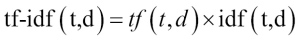

In [4]:
from IPython.display import Image
Image("/Users/surthi/gitrepos/ml-notes/images/tfidf.jpg")

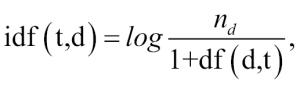

In [5]:
# where n(d) is the total number of documents, and df(d, t) is the number of documents d that contain the term t.
# log is used to make sure that low document frequencies are not given too much weight
Image("/Users/surthi/gitrepos/ml-notes/images/idf.jpg")

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
np.set_printoptions(precision=2)
print tfidf.fit_transform(count.fit_transform(docs)).toarray()


[[ 0.    0.43  0.56  0.56  0.    0.43  0.  ]
 [ 0.    0.43  0.    0.    0.56  0.43  0.56]
 [ 0.4   0.48  0.31  0.31  0.31  0.48  0.31]]


# Observation:
- the word "is" had the largest term frequency in the 3rd document, being the most frequently occurring word. However, after transforming the same feature vector into tf-idfs, we see that the word is is now associated with a relatively small tf-idf (0.31) in document 3 since it is also contained in documents 1 and 2 and thus is unlikely to contain any useful, discriminatory information.

# Cleaning text data
The first important step—before we build our bag-of-words model—is to clean the text data by stripping it of all unwanted characters. 

<h3>Cleaning Step#1: Preprocessor</h3>
<li> remove all html markup </li>
<li> remove punctuation marks </li>
<li> keep emoticon characters such as ":)" as its useful in sentiment analysis </li>

In [7]:
import re

# implement preprocessor
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # removes html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # store emot icons
    text = re.sub('[\W]+', ' ', text.lower()) # remove non-word chars
    text = text + ''.join(emoticons).replace('-', '') # add emoticons at the end of the doc
    return text

# test preprocessor
print preprocessor("</a>This :) is :( a test :-)!")

# apply preprocessor on df['review']
df['review'] = df['review'].apply(preprocessor)

this is a test :):(:)


<h3>Cleaning Step#2: Tokenizer [split by space] </h3>

In [8]:
def tokenizer(text):
    return text.split()

<h3> Cleaning Step#3: Word Stemming</h3>
Its the process of transforming a word into its root form that allows us to map related words to the same stem.

In [9]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()    
def stem(text):
    return [porter.stem(word) for word in tokenizer(text)]

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

print stem("runners like running and thus they run")
    

[u'runner', u'like', u'run', u'and', u'thu', u'they', u'run']


<h3> Cleaning Step#4: StopWords Removal</h3>

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

text = "a runner likes running and runs a lot"
print [w for w in stem(text) if w not in stop]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/surthi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[u'runner', u'like', u'run', u'run', u'lot']


In [16]:
X_train = df.loc[:25000,'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:,'review'].values
y_test = df.loc[25000:, 'sentiment'].values

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer with its default settings (use_idf=True, smooth_idf=True, and norm='l2')
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

print "Starting.."

param_grid = [{
        'vect__ngram_range': [(1,1)],
        'vect__stop_words': [(stop, None)],
        'vect__tokenizer': [tokenizer, tokenizer_porter],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0]
    },{
        'vect__ngram_range': [(1,1)],
        'vect__stop_words': [(stop, None)],
        'vect__tokenizer': [tokenizer, tokenizer_porter],
        'vect__use_idf':[False],
        'vect__norm':[None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0]
    }]
param_grid1 = [{'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}
             ]
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))]) 
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid1, cv=5, verbose=True, n_jobs=-1)
print "Fitting.."
gs_lr_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Starting..
Fitting..
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 73.3min finished


Best parameter set: {'vect__ngram_range': (1, 1), 'vect__tokenizer': <function tokenizer at 0x10e4a78c0>, 'clf__penalty': 'l2', 'clf__C': 10.0, 'vect__stop_words': None} 


In [15]:
print "Best score: %.3f" %(gs_lr_tfidf.best_score_)
clf = gs_lr_tfidf.best_estimator_
print "Test score: %.3f" %(clf.score(X_test, y_test))



Best score: 0.892
Test score: 0.897


# Note
http://nbviewer.jupyter.org/github/erfannoury/TextClassification/blob/master/sklearn-text%20classification.ipynb good reference to classify text
Although NLTK is not the focus of the chapter, I highly recommend you to visit the NLTK website as well as the official NLTK book, which is freely available at http://www.nltk.org/book/, if you are interested in more advanced applications in NLP.